In [27]:
import pandas as pd
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDRegressor
from sklearn.svm import LinearSVC, SVR, LinearSVR
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold, GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, MultiTaskElasticNetCV, OrthogonalMatchingPursuitCV, ARDRegression, Ridge
from scipy.stats import gmean
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path
import gc
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from scipy.signal import periodogram
from tqdm import tqdm_notebook
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")
gc.enable()
gc.collect()

6124

In [28]:
random_state_fix = 142018
np.random.seed(random_state_fix)
# Lets go ahead  and have a look at data

DATA_PATH = "/Users/lemeillefrancois/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/01 - Data/" 
#DATA_PATH = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/01 - Data/" 
Res_Path = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/03 - Résultats/" 
Test_Path = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/01 - Data/test/" 

To Do :
    Compléter FE 
    Ajouter élément de traitement de signal
    regarder sta lta 
    Construire NN 
    Opti LGBM

# Import des données et EDA

In [29]:
def read_file(path, filename, sep=','):
    file = pd.read_csv(str(path)+filename)
    return file

In [30]:
train = read_file(DATA_PATH, "new_train_1s_24f.csv")
X_test = read_file(DATA_PATH, "new_test_24f.csv")
print(train.shape, X_test.shape)

(4178, 29) (2624, 26)


In [31]:
def train_prep(train, col_to_drop):
    x_train = train.drop(col_to_drop, axis=1)
    y_train = train['time_to_failure']
    y_quake = train['quake_number'].fillna(0).astype(int)
    IDs = X_test.index
    return x_train, y_train, y_quake, IDs


In [32]:
col_to_drop = ['time_to_failure', 'first_time_to_failure', 'quake_number']
x_train, y_train, y_quake, _ = train_prep(train, col_to_drop)

In [33]:
print("Train and test shapes", x_train.shape, X_test.shape)

Train and test shapes (4178, 26) (2624, 26)


In [34]:
gc.collect()

154

## Catégoriser y_train

In [35]:
def binning_y(y_train, n_bins=16): 
    return pd.cut(y_train, n_bins, retbins=True, labels=range(n_bins))[0]

In [36]:
y_train_bin = binning_y(y_train)

# FE et traitement des données

In [37]:
submission = pd.read_csv(str(Path(DATA_PATH) / "sample_submission.csv"), index_col = 'seg_id')
print(submission.shape)

(2624, 1)


## Scaler et transfo finale

In [38]:
def scale_data(x_train, X_test):
    scaler = StandardScaler()
    x_test = X_test.copy()
    scaler.fit(x_train)
    x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=x_train.columns)
    return x_train_scaled, x_test_scaled

In [39]:
x_train_scaled, x_test_scaled = scale_data(x_train, X_test)

# BO sur LGBM

In [40]:
from bayes_opt import BayesianOptimization
n_fold=5

In [41]:
train_data = lgb.Dataset(data=x_train, label=y_train, free_raw_data=False)

params_bo = {
         "min_data_in_leaf": 80, 
         "boosting": "gbdt", 'n_estimators': 5000,
        "verbosity": -1, "metric": 'mae', 'learning_rate':0.005
    }

def lgb_eval_reg(num_leaves, feature_fraction, max_depth, 
                 bagging_freq, reg_alpha, reg_lambda,  subsample):

   
    params_bo['objective']='regression' 
    
    params_bo['subsample'] = subsample
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_huber(num_leaves, feature_fraction, max_depth, 
                    bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['objective']='huber'
    params_bo['subsample'] = subsample
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_gamma(num_leaves, feature_fraction, max_depth, 
                   bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['subsample'] = subsample

    params_bo['objective']='gamma'
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_fair(num_leaves, feature_fraction, max_depth, 
                   bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['subsample'] = subsample

    params_bo['objective']='fair'
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    
    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_mae(num_leaves, feature_fraction, max_depth, 
                 bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['subsample'] = subsample

    params_bo['objective']='mae'
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_regL1(num_leaves, feature_fraction, max_depth, 
                 bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['subsample'] = subsample

    params_bo['objective']='regression_l1'
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

def lgb_eval_tweedie(num_leaves, feature_fraction, max_depth, 
                 bagging_freq, reg_alpha, reg_lambda,  subsample):
    
    params_bo['subsample'] = subsample

    params_bo['objective']='tweedie'
    params_bo["bagging_freq"] = int(round(bagging_freq))
    params_bo["reg_alpha"] = reg_alpha
    params_bo["reg_lambda"] = reg_lambda
    params_bo['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params_bo['max_depth'] = int(round(max_depth))
    params_bo['num_leaves'] = int(round(num_leaves))
    
    

    cv_result = lgb.cv(params_bo, train_data, KFold(n_fold, shuffle=True, random_state=2911).split(x_train, y_train_bin), seed=random_state_fix, verbose_eval=1000, stratified=False,
                       early_stopping_rounds=50, shuffle=True)
    return (-1.0 * np.array(cv_result['l1-mean'])).max()

In [42]:
dict_opt = {'num_leaves': (2, 100), 'feature_fraction': (0.01, 1), 'max_depth': (2, 80),
            "reg_alpha": (0, 0.9), "reg_lambda": (0, 0.9),
            "bagging_freq": (1, 10), 'subsample': (0.4, 1)}

def lgb_BO(obj='reg', dict_opt=dict_opt, init_points=5, n_iter=20):
    if obj == 'reg':
        lgbBO_reg = BayesianOptimization(lgb_eval_reg, dict_opt)
        lgbBO_reg.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_reg.max
    elif obj == 'huber':
        lgbBO_huber = BayesianOptimization(lgb_eval_huber, dict_opt)
        lgbBO_huber.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_huber.max
    elif obj == 'fair':
        lgbBO_fair = BayesianOptimization(lgb_eval_fair, dict_opt)
        lgbBO_fair.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_fair.max
    elif obj == 'gamma':
        lgbBO_gamma = BayesianOptimization(lgb_eval_gamma, dict_opt)
        lgbBO_gamma.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_gamma.max
    elif obj == 'mae':
        lgbBO_mae = BayesianOptimization(lgb_eval_mae, dict_opt)
        lgbBO_mae.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_mae.max  
    elif obj == 'regL1':
        lgbBO_regL1 = BayesianOptimization(lgb_eval_regL1, dict_opt)
        lgbBO_regL1.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_regL1.max        
    elif obj == 'tweedie':
        lgbBO_tweedie = BayesianOptimization(lgb_eval_tweedie, dict_opt)
        lgbBO_tweedie.maximize(init_points=init_points, n_iter=n_iter, acq='ei')
        best_param = lgbBO_tweedie.max          

    return best_param

In [43]:
#param_reg = lgb_BO('reg')
#param_gamma = lgb_BO('gamma')
#param_fair = lgb_BO('fair')
#param_mae = lgb_BO('mae')
#param_huber = lgb_BO('huber')
#param_regL1 = lgb_BO('regL1')
#param_tweedie = lgb_BO('tweedie')

In [44]:
#param_fair

# Modèles

## Validation Strategy 

In [45]:
n_fold = 5
# cvlist = list(StratifiedKFold(n_fold, shuffle=True, random_state=1905).split(x_train, y_train_bin))
cvlist = list(KFold(n_fold, shuffle=True, random_state=1905).split(x_train, y_train))
# cvlist = list(StratifiedShuffleSplit(n_fold, random_state=1905).split(x_train, y_train_bin))
# cvlist = list(GroupKFold(5).split(x_train, y_train, y_quake))

In [46]:
print('ready')

ready


In [47]:
def train_lgb(train, target, params, ES=1000, plot_imp=True):
    nb_features = train.shape[1]
    feature_importance_df = pd.DataFrame()
    
    y_preds_lgb = np.zeros((len(y_train)))
    test_preds_allfolds = []
    for i, (tr_idx, val_idx) in enumerate(cvlist):
        X_dev, y_dev = train.iloc[tr_idx], target.iloc[tr_idx]
        X_val, y_val = train.iloc[val_idx], target.iloc[val_idx]
        model = lgb.LGBMRegressor(**params)
        model.fit(X_dev, y_dev, eval_set=[(X_dev, y_dev), (X_val, y_val)],
                  eval_metric="mae", verbose=3000, early_stopping_rounds=ES)

        val_preds = model.predict(
            X_val, num_iteration=model.best_iteration_)
        y_preds_lgb[val_idx] = val_preds.reshape(-1, )

        test_preds = model.predict(
            x_test_scaled.values, num_iteration=model.best_iteration_)
        test_preds_allfolds.append(test_preds)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = x_test_scaled.columns
        fold_importance_df["importance"] = model.feature_importances_[
            :len(x_test_scaled.columns)]
        fold_importance_df["fold"] = str(i)
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0)

        print("Score for fold {} is {}".format(
            i, mean_absolute_error(y_val, val_preds)))
        # break
    print("Overall Score for oof predictions ",
          mean_absolute_error(y_train, y_preds_lgb))

    if plot_imp is True:
        cols = (feature_importance_df[["Feature", "importance"]]
                .groupby("Feature")
                .mean()
                .sort_values(by="importance", ascending=False)[:200].index)
        best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(
            cols)]

        plt.figure(figsize=(18, 8))
        sns.barplot(x="importance", y="Feature", data=best_features.sort_values(
            by="importance", ascending=False))
        plt.title('LightGBM Features (averaged over folds)')
        plt.tight_layout()
        
    gc.collect()
    y_test_pred = np.mean(test_preds_allfolds, 0)
    return y_test_pred, y_preds_lgb

## LGBM Regression 

### Regression

In [48]:
lgb_params_reg = {'objective':'regression',
                  
 'bagging_freq': 2,
  'feature_fraction': 0.3631117147672091,
  'learning_rate': 0.027110499557670642,
  'max_depth': 3,
  'min_data_in_leaf': 20,
  'min_split_gain': 0.30371723122308014,
  'num_leaves': 10,
  'reg_alpha': 0.318589978388017,
  'reg_lambda': 0.812545319410737,
  'subsample': 0.9867411862988433,    
        "n_estimators":20000,
        "boosting": "gbdt",      
        "metric": 'mae',      
         "verbosity": -1,
         "random_state": 2911}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[482]	training's l1: 1.79727	valid_1's l1: 2.1283
Score for fold 0 is 2.1283003793107245
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[242]	training's l1: 1.93922	valid_1's l1: 1.97767
Score for fold 1 is 1.977673686365774
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[324]	training's l1: 1.87078	valid_1's l1: 2.06549
Score for fold 2 is 2.0654920764188143
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[232]	training's l1: 1.92895	valid_1's l1: 2.04609
Score for fold 3 is 2.046090893377441
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[348]	training's l1: 1.86222	valid_1's l1: 2.05472
Score for fold 4 is 2.0547184852921
Overall Score for oof predictions  2.054457043078207


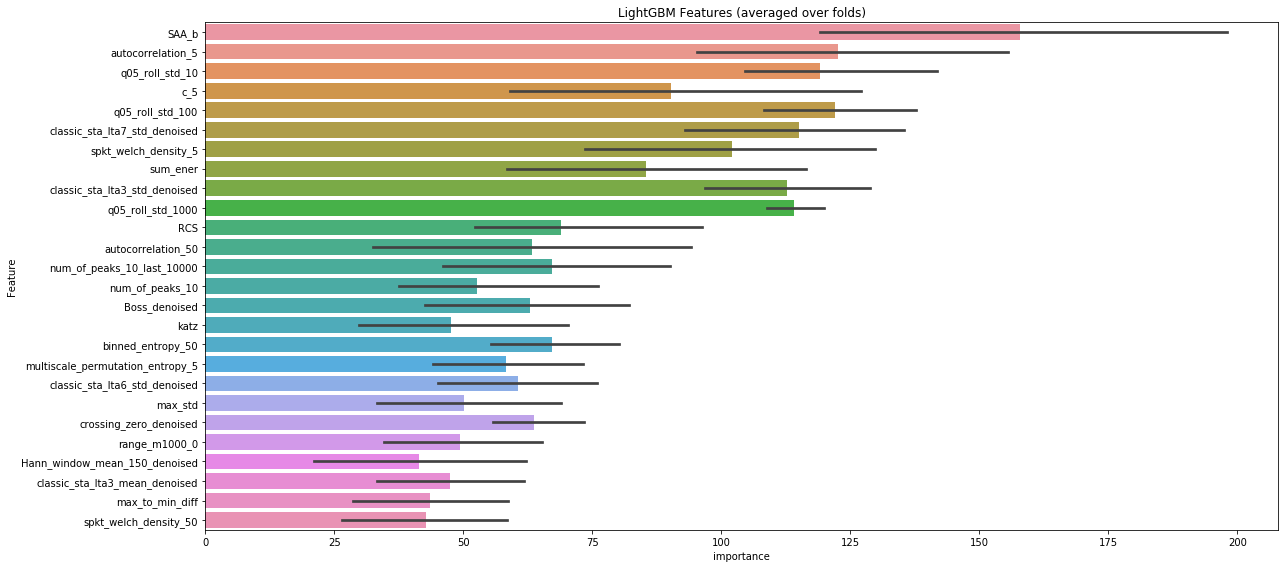

In [49]:
y_test_lgb_reg, oof_reg = train_lgb(x_train_scaled, y_train, lgb_params_reg)
submission['time_to_failure'] = y_test_lgb_reg
submission.to_csv("lgb_sub_reg.csv")

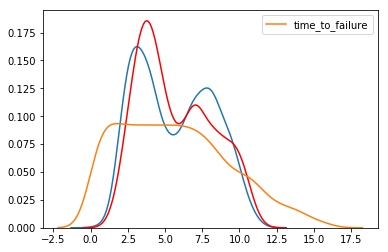

In [50]:
sns.kdeplot(oof_reg)
sns.kdeplot(y_test_lgb_reg, color='red')
sns.kdeplot(y_train)

### Fair

In [51]:
params_fair={'objective':'fair',
'bagging_freq': 1,
  'feature_fraction': 0.9083067210019933,
  'max_depth': 30,
  'num_leaves': 4,
  'reg_alpha': 0.8,
  'reg_lambda': 0.1,
  'subsample': 0.7893936135599213, 
             'learing_rate':0.008,
        "n_estimators": 20000,
        "boosting": "gbdt",      
        "metric": 'mae',    
         "verbosity": -1,
         "random_state": random_state_fix}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[70]	training's l1: 1.87649	valid_1's l1: 2.09858
Score for fold 0 is 2.098582513613965
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[96]	training's l1: 1.89664	valid_1's l1: 1.92694
Score for fold 1 is 1.92694472868697
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[65]	training's l1: 1.90801	valid_1's l1: 2.04704
Score for fold 2 is 2.0470407947989746
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[59]	training's l1: 1.92838	valid_1's l1: 1.99631
Score for fold 3 is 1.9963081409329735
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[79]	training's l1: 1.88746	valid_1's l1: 2.02948
Score for fold 4 is 2.029477377723071
Overall Score for oof predictions  2.0196739557427765


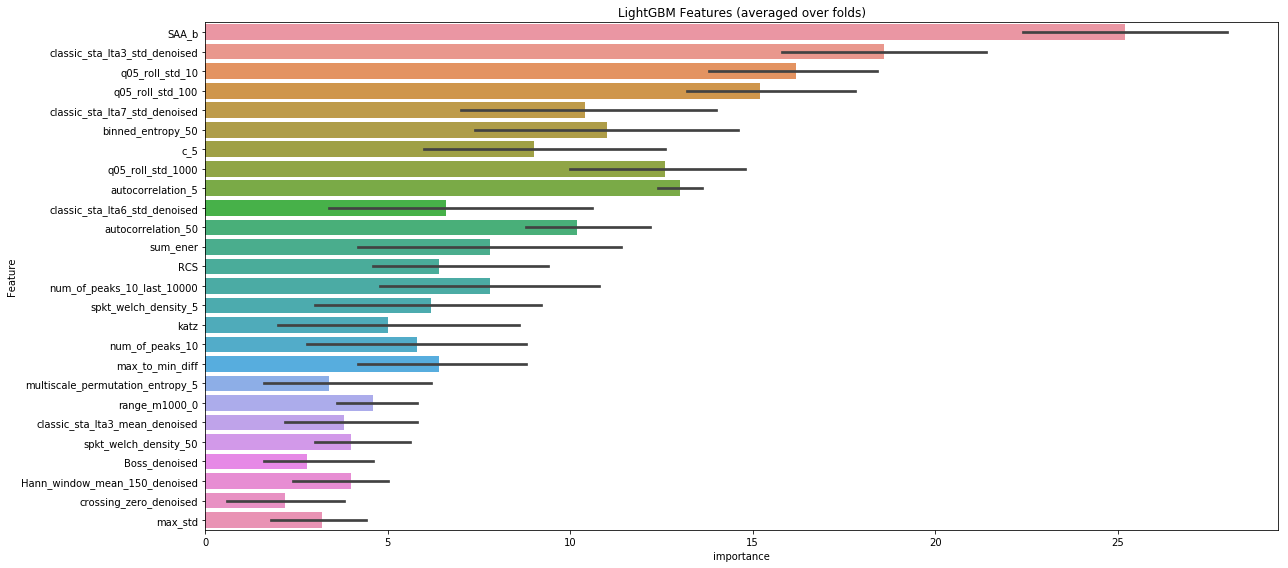

In [52]:
y_test_lgb_fair, oof_fair = train_lgb(x_train_scaled, y_train, params_fair)
submission['time_to_failure'] = y_test_lgb_fair
submission.to_csv("lgb_sub_fair.csv")

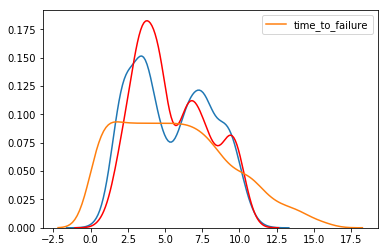

In [53]:
sns.kdeplot(oof_fair)
sns.kdeplot(y_test_lgb_fair, color='red')
sns.kdeplot(y_train)

###  Huber

In [54]:
params_huber={'objective':'huber',
              
  'bagging_freq': 1,
  'feature_fraction': 0.7,
  'learning_rate': 0.02,
  'max_depth': 79,
  'min_data_in_leaf': 25,
  'min_split_gain': 0.7,
  'num_leaves': 24,
  'reg_alpha': 0.88,
  'reg_lambda': 0.75,
  'subsample': 0.92,
              
              "min_data_in_leaf": 80,
           "n_estimators":20000,       
        "boosting": "gbdt",      
        "metric": 'mae',     
         "verbosity": -1,
         "random_state": random_state_fix}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[535]	training's l1: 1.74148	valid_1's l1: 2.10618
Score for fold 0 is 2.106180820686759
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1091]	training's l1: 1.59302	valid_1's l1: 1.93371
Score for fold 1 is 1.9337130959126914
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[559]	training's l1: 1.73605	valid_1's l1: 2.05835
Score for fold 2 is 2.058351984498321
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[594]	training's l1: 1.73912	valid_1's l1: 1.99228
Score for fold 3 is 1.992276724207607
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[649]	training's l1: 1.70193	valid_1's l1: 2.04254
Score for fold 4 is 2.0425365403666134
Overall Score for oof predictions  2.026616239645096


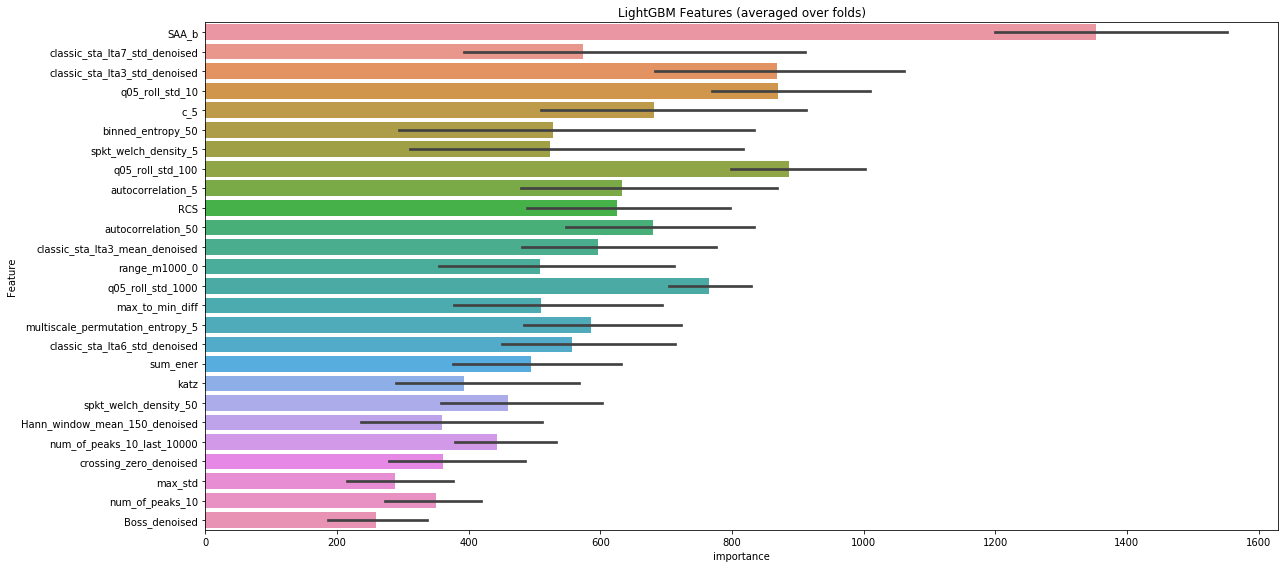

In [55]:
y_test_lgb_huber, oof_huber = train_lgb(x_train_scaled, y_train, params_huber)
submission['time_to_failure'] = y_test_lgb_huber
submission.to_csv("lgb_sub_huber.csv")

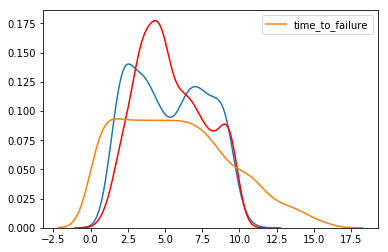

In [ ]:
sns.kdeplot(oof_huber)
sns.kdeplot(y_test_lgb_huber, color='red')
sns.kdeplot(y_train)

### Gamma

In [ ]:
params_gamma = {'objective':'gamma', 
'bagging_freq': 8,
  'feature_fraction': 0.20602880534146054,
  'learning_rate': 0.006464780588174548,
  'max_depth': 77,
  'min_data_in_leaf': 22,
  'min_split_gain': 0.8719481245970758,
  'num_leaves': 100,
  'reg_alpha': 0.39861803394844936,
  'reg_lambda': 0.008948724279917608,
  'subsample': 0.9232724301896005,
    "n_estimators":20000,
        "boosting": "gbdt",      
        "metric": 'mae',      
         "verbosity": -1,
         "random_state": random_state_fix}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[834]	training's l1: 1.82081	valid_1's l1: 2.12137
Score for fold 0 is 2.1216354730071543
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1152]	training's l1: 1.85576	valid_1's l1: 1.96592
Score for fold 1 is 1.9663881308462996
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[617]	training's l1: 1.84117	valid_1's l1: 2.05794
Score for fold 2 is 2.057960091389588
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[523]	training's l1: 1.85353	valid_1's l1: 2.02752
Score for fold 3 is 2.0275240390700264
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[696]	training's l1: 1.83738	valid_1's l1: 2.04939
Score for fold 4 is 2.0497171196588244
Overall Score for oof predictions  2.0446478546581552


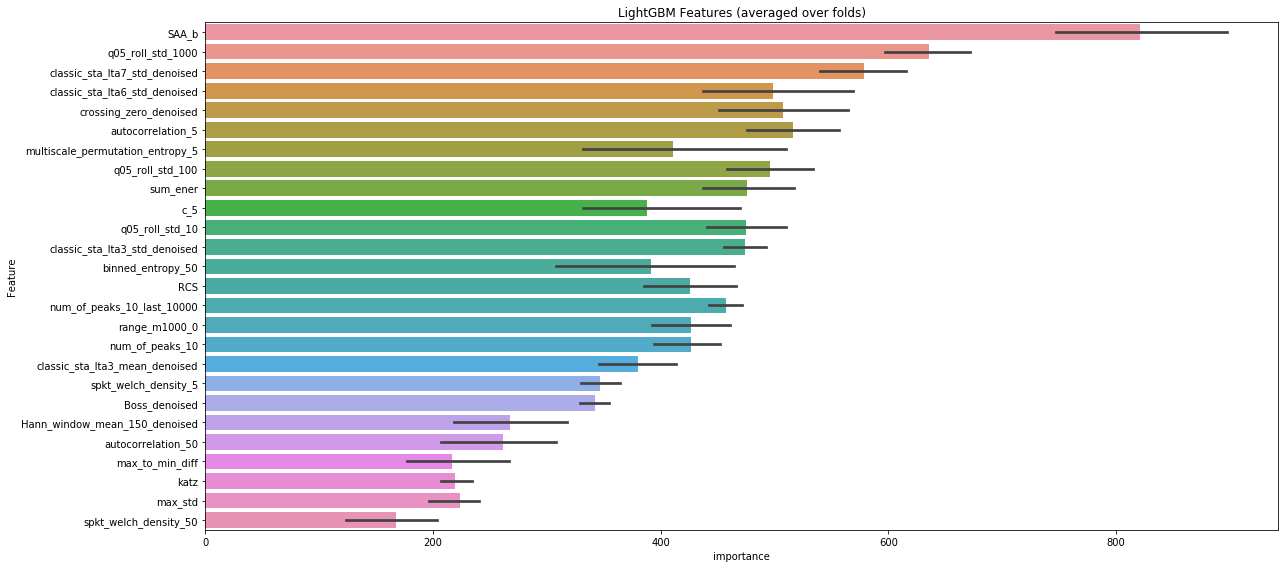

In [ ]:
y_test_lgb_gamma, oof_gamma = train_lgb(x_train_scaled, y_train, params_gamma)
submission['time_to_failure'] = y_test_lgb_gamma
submission.to_csv("lgb_sub_gamma.csv")

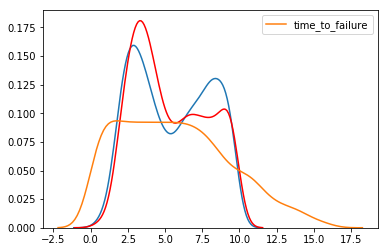

In [ ]:
sns.kdeplot(oof_gamma)
sns.kdeplot(y_test_lgb_gamma, color='red')
sns.kdeplot(y_train)

In [ ]:
gc.collect()

6104

### Mae

In [ ]:
params_mae={'objective':'mae',    
 'bagging_freq': 8,
  'feature_fraction': 0.87,
  'max_depth': 30,
  'num_leaves': 10,
  'reg_alpha': 0.65,
  'reg_lambda': 0.87,
  'subsample': 0.68,
            
            'learning_rate': 0.005,
            "min_data_in_leaf": 80,
        "n_estimators":20000,
        "boosting": "gbdt",      
        "metric": 'mae',         
         "verbosity": -1,
         "random_state": random_state_fix}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[839]	training's l1: 1.83716	valid_1's l1: 2.10015
Score for fold 0 is 2.1001521470104794
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1784]	training's l1: 1.76963	valid_1's l1: 1.92606
Score for fold 1 is 1.9260616746916632
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[712]	training's l1: 1.87363	valid_1's l1: 2.05136
Score for fold 2 is 2.0513572530551722
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[856]	training's l1: 1.86401	valid_1's l1: 1.99708
Score for fold 3 is 1.997081158187909
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[667]	training's l1: 1.88625	valid_1's l1: 2.03865
Score for fold 4 is 2.0386472974393337
Overall Score for oof predictions  2.022662201758225


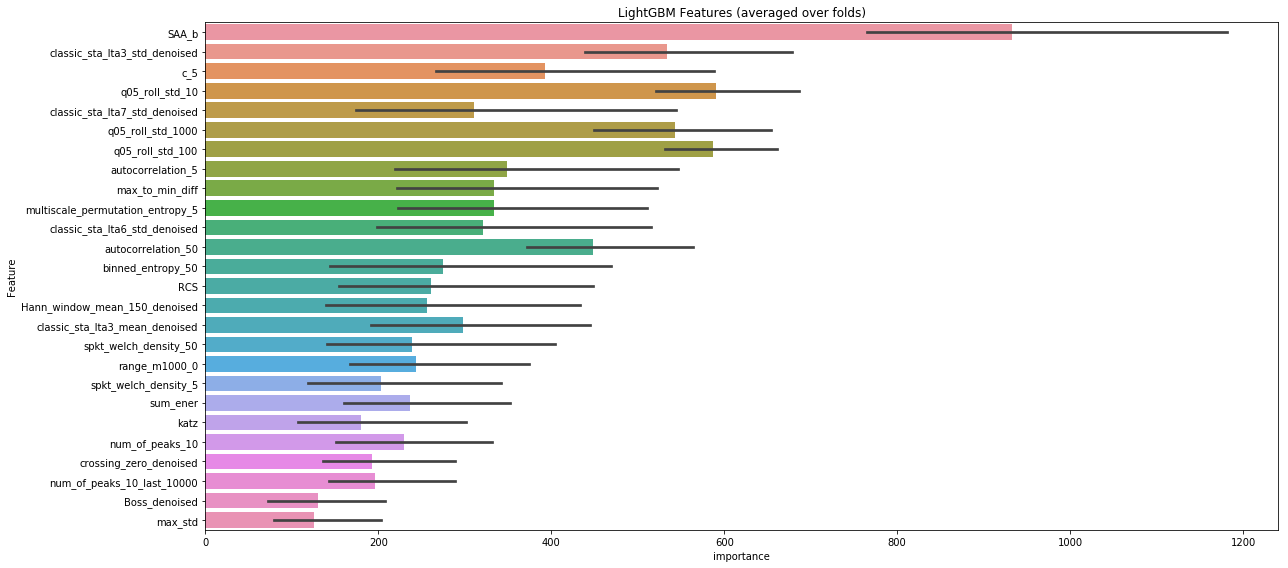

In [ ]:
y_test_lgb_mae, oof_mae = train_lgb(x_train_scaled, y_train, params_mae)
submission['time_to_failure'] = y_test_lgb_mae
submission.to_csv("lgb_sub_mae.csv")

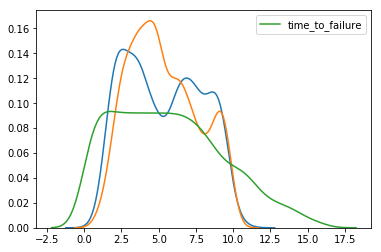

In [ ]:
sns.kdeplot(oof_mae)
sns.kdeplot(y_test_lgb_mae)
sns.kdeplot(y_train)

### Regression_L1

In [ ]:
params_regL1={'objective':'regression_l1', 
              'bagging_freq': 9,
  'feature_fraction': 0.4208008763559022,
  'max_depth': 57,
  'num_leaves': 35,
  'reg_alpha': 0.5599361649265783,
  'reg_lambda': 0.65791275149032227,
  'subsample': 0.5578114066165113,
              
              'learning_rate': 0.005,
            "min_data_in_leaf": 80,
        "n_estimators":20000, 
        "boosting": "gbdt",      
        "metric": 'mae',         
         "verbosity": -1,
         "random_state": random_state_fix}

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[939]	training's l1: 1.7694	valid_1's l1: 2.11764
Score for fold 0 is 2.1176420008887797
Training until validation scores don't improve for 1000 rounds.
[3000]	training's l1: 1.57001	valid_1's l1: 1.94287
Early stopping, best iteration is:
[2009]	training's l1: 1.65443	valid_1's l1: 1.94013
Score for fold 1 is 1.9401302938062726
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[766]	training's l1: 1.82005	valid_1's l1: 2.06154
Score for fold 2 is 2.0615433952516704
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[1415]	training's l1: 1.71068	valid_1's l1: 1.99858
Score for fold 3 is 1.9985846209636775
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[774]	training's l1: 1.82425	valid_1's l1: 2.05441
Score for fold 4 is 2.0544073255123365
Ov

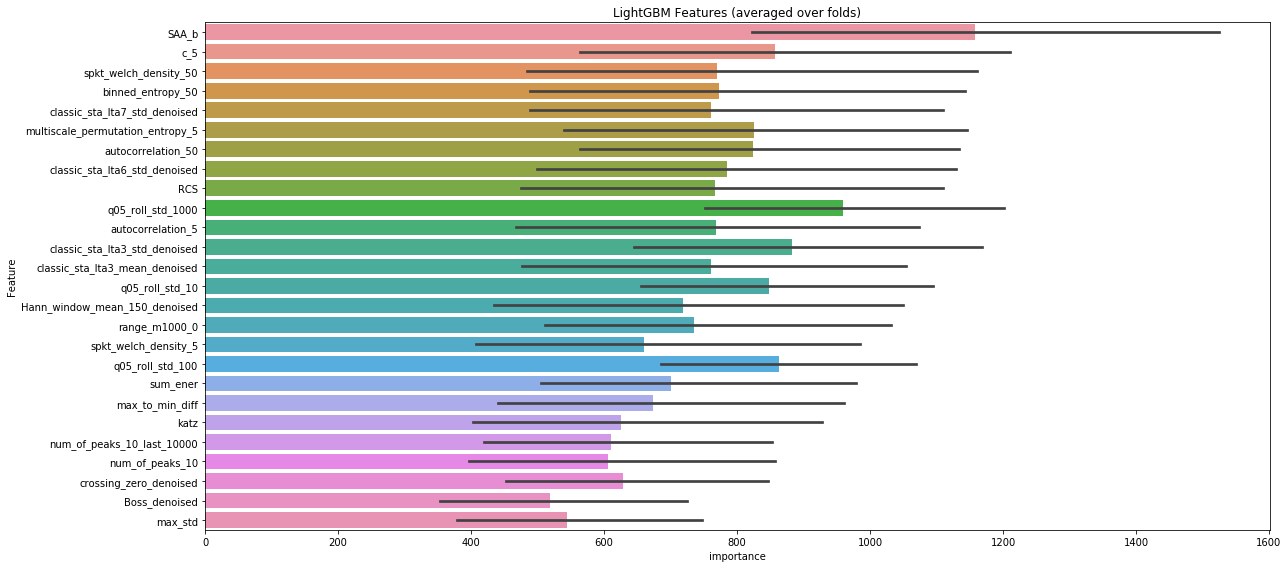

In [ ]:
y_test_lgb_regL1, oof_regL1 = train_lgb(x_train_scaled, y_train, params_regL1)
submission['time_to_failure'] = y_test_lgb_regL1
submission.to_csv("lgb_sub_regL1.csv")

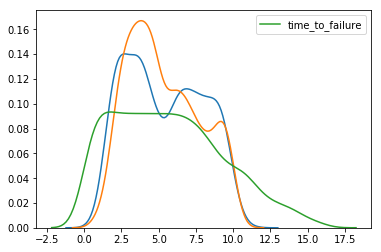

In [ ]:
sns.kdeplot(oof_regL1)
sns.kdeplot(y_test_lgb_regL1)
sns.kdeplot(y_train)

### Tweedie

In [ ]:
params_tweedie={'objective':'tweedie', 
                'bagging_freq': 3,
  'feature_fraction': 0.7,
  'max_depth': 50,
  'num_leaves': 24,
  'reg_alpha': 0.7,
  'reg_lambda': 0.75,
  'subsample': 0.92,
                
     'learning_rate': 0.005,
    "min_data_in_leaf": 80,
    "n_estimators":20000,
        "boosting": "gbdt",      
        "metric": 'mae',         
         "verbosity": -1,
         "random_state": random_state_fix}

In [ ]:
y_test_lgb_tweedie, oof_tweedie = train_lgb(x_train_scaled, y_train, params_tweedie)
submission['time_to_failure'] = y_test_lgb_tweedie
submission.to_csv("lgb_sub_tweedie.csv")

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[847]	training's l1: 1.73935	valid_1's l1: 2.11244
Score for fold 0 is 2.1124364601182832
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[858]	training's l1: 1.7696	valid_1's l1: 1.9664
Score for fold 1 is 1.9664033960754372
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[755]	training's l1: 1.77411	valid_1's l1: 2.07673
Score for fold 2 is 2.076734561790969
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[612]	training's l1: 1.83584	valid_1's l1: 2.04172
Score for fold 3 is 2.041720156836916
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[665]	training's l1: 1.80367	valid_1's l1: 2.05448
Score for fold 4 is 2.0544762430723167
Overall Score for oof predictions  2.050355243503928


In [ ]:
sns.kdeplot(oof_tweedie)
sns.kdeplot(y_test_lgb_tweedie)
sns.kdeplot(y_train)

In [ ]:
gc.collect()

## Viz

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(oof_reg)
sns.kdeplot(oof_fair)
sns.kdeplot(oof_gamma)
sns.kdeplot(oof_huber)
sns.kdeplot(oof_mae)
sns.kdeplot(oof_regL1)
sns.kdeplot(oof_tweedie)
sns.kdeplot(y_train)


In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(y_test_lgb_mae)
sns.kdeplot(y_test_lgb_reg)
sns.kdeplot(y_test_lgb_fair)
sns.kdeplot(y_test_lgb_gamma)
sns.kdeplot(y_test_lgb_huber)
sns.kdeplot(y_test_lgb_regL1)
sns.kdeplot(y_test_lgb_tweedie)

## Blend LGBs

In [ ]:
y_blend_lgb = 1/7*(oof_reg+oof_fair+oof_gamma+
                   oof_huber+oof_mae+oof_regL1+oof_tweedie)
y_blend_lgb2 = (0.05*oof_reg+0.2*oof_fair+0.3*oof_gamma+
                0.15*oof_huber+0.1*oof_mae+
               0.1*oof_regL1+ 0.1*oof_tweedie)

print(mean_absolute_error(y_train, oof_reg))
print(mean_absolute_error(y_train, oof_fair))
print(mean_absolute_error(y_train, oof_gamma))
print(mean_absolute_error(y_train, oof_huber))
print(mean_absolute_error(y_train, oof_mae))
print(mean_absolute_error(y_train, oof_regL1))
print(mean_absolute_error(y_train, oof_tweedie))
print(mean_absolute_error(y_train, y_blend_lgb))
print(mean_absolute_error(y_train, y_blend_lgb2))

In [ ]:
y_test_blend_lgb = 1/7*(y_test_lgb_reg+y_test_lgb_fair+y_test_lgb_gamma+y_test_lgb_huber+y_test_lgb_mae
                       +y_test_lgb_regL1+y_test_lgb_tweedie)
submission['time_to_failure'] = y_test_blend_lgb
submission.to_csv("lgb_subVblend.csv")

y_test_blend_lgb2 = (0.05*y_test_lgb_reg+0.2*y_test_lgb_fair+
            0.3*y_test_lgb_gamma+0.1*y_test_lgb_huber+0.15*y_test_lgb_mae+0.1*y_test_lgb_regL1+0.1*y_test_lgb_tweedie )

submission['time_to_failure'] = y_test_blend_lgb2
submission.to_csv("lgb_subVblend2.csv")

In [ ]:
sns.kdeplot(y_test_blend_lgb)
sns.kdeplot(y_test_blend_lgb2)

In [ ]:
print(np.mean(y_test_lgb_reg))
print(np.mean(y_test_lgb_fair))
print(np.mean(y_test_lgb_gamma))
print(np.mean(y_test_lgb_huber))
print(np.mean(y_test_lgb_mae))
print(np.mean(y_test_blend_lgb))
print(np.mean(y_test_blend_lgb2))

In [ ]:
print(y_test_lgb_reg.max())
print(y_test_lgb_fair.max())
print(y_test_lgb_gamma.max())
print(y_test_lgb_huber.max())
print(y_test_lgb_mae.max())
print(y_test_blend_lgb.max())
print(y_test_blend_lgb2.max())

In [ ]:
print(y_test_blend_lgb.max())

In [ ]:
print('score is ', mean_absolute_error(y_train, y_blend_lgb) )

In [ ]:
stacked_res = pd.concat([pd.Series(oof_reg),
                         pd.Series(oof_fair),
                         pd.Series(oof_gamma),
                         pd.Series(oof_huber),
                         pd.Series(oof_mae),
                         pd.Series(oof_regL1),
                         pd.Series(oof_tweedie), y_train], axis=1)

In [ ]:
stacked_res.sample(15)

# SVR

In [ ]:
# parametersGrid = {"C": [0.05, 0.1, 0.5, 1, 5,10]}

# mod_SVR = SVR()
# mod_SVR_best = GridSearchCV(mod_SVR, parametersGrid, cv=3, verbose=10)
# mod_SVR_best.fit(x_train_scaled, y_train)
# print(mod_SVR_best.best_params_)

In [ ]:
mod_SVR = SVR(C=0.5)
y_preds_SVR = cross_val_predict(mod_SVR, x_train_scaled, y_train, cv=cvlist, verbose=10)
print(mean_absolute_error(y_train, y_preds_SVR))
model_svr = SVR(C=0.5)
model_svr.fit(x_train_scaled, y_train)
y_test_preds_SVR = model_svr.predict(x_test_scaled)

In [ ]:
sns.kdeplot(y_preds_SVR)
sns.kdeplot(y_test_preds_SVR)
sns.kdeplot(y_train)

# Stacking 

In [ ]:
stacked_train = pd.DataFrame()
stacked_train['reg'] = oof_reg
stacked_train['fair'] = oof_fair
stacked_train['gamma'] = oof_gamma
stacked_train['huber'] = oof_huber
stacked_train['mae'] = oof_mae
stacked_train['regl1'] = oof_regL1
stacked_train['tweedie'] = oof_tweedie
# stacked_train['NN'] = y_preds_nn
stacked_train['SVR'] = y_preds_SVR
stacked_train['mean'] = stacked_train.mean(axis=1)
stacked_train['target'] = y_train

In [ ]:
stacked_train.sample(10)

In [ ]:
print(mean_absolute_error(y_train, stacked_train['mean']))
print('score is ', mean_absolute_error(y_train, y_blend_lgb) )

In [ ]:
submission['time_to_failure'] = stacked_train['mean']
submission.to_csv("mean_all.csv")

In [ ]:
stacked_test = pd.DataFrame()
stacked_test['reg'] = y_test_lgb_reg
stacked_test['fair'] = y_test_lgb_fair
stacked_test['gamma'] = y_test_lgb_gamma
stacked_test['huber'] = y_test_lgb_huber
stacked_test['mae'] = y_test_lgb_mae
stacked_test['regl1'] = y_test_lgb_regL1
stacked_test['tweedie'] = y_test_lgb_tweedie
# stacked_test['NN'] = y_test_nn
stacked_test['SVR'] = y_test_preds_SVR
stacked_test['mean'] = stacked_test.mean(axis=1)

In [ ]:
stacked_test.sample(10)

In [ ]:
gc.collect()